# Credit Card Fraud Detection

https://www.kaggle.com/mlg-ulb/creditcardfraud

## Introduction

Billions of dollars of loss are caused every year due to fraudulent credit card transactions. The design of efficient fraud detection algorithms is key to reducing these losses, and more algorithms rely on advanced machine learning techniques to assist fraud investigators. The design of fraud detection algorithms is however particularly challenging due to non-stationary distribution of the data, highly imbalanced classes distributions and continuous streams of transactions. At the same time public data are scarcely available for confidentiality issues, leaving unanswered many questions about which is the best strategy to handle this issue.

The dataset here contains transactions made by credit cards in September 2013 by european cardholders. This dataset from Kaggle is available here. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we do not have access to the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are ‘Time’ and ‘Amount’. Feature ‘Time’ contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature ‘Amount’ is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature ‘Class’ is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The objective of the project is to train a machine learning algorithm on the dataset to successfully predict fraudulent transactions.

Given the class imbalance ratio, we will be using measuring the accuracy using the Area Under the Precision-Recall Curve (AUC). Confusion matrix accuracy is not meaningful for unbalanced classification.

We will also use different sampling techniques (details below) on the train dataset in order to address the issue of imbalanced classes while training our models.


## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Read data
data = pd.read_csv('F:/Credit_Card_Fraud/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploring the data

0    284315
1       492
Name: Class, dtype: int64

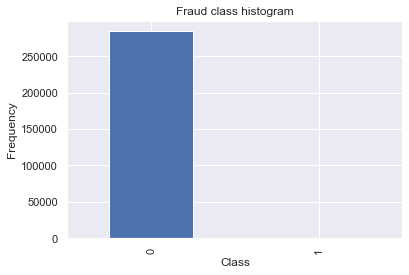

In [3]:
pd.value_counts(data['Class']).plot.bar()
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
data['Class'].value_counts()

In [4]:
print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


## Scaling

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()

data['scaled_amount'] = std_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = std_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)
scaled_amount = data['scaled_amount']
scaled_time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
data.insert(1, 'scaled_time', scaled_time)

In [6]:
data.head(10)

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
5,-0.338556,-1.996541,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0
6,-0.333279,-1.996499,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,...,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,0
7,-0.190107,-1.996436,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,...,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0
8,0.019392,-1.996436,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,...,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0
9,-0.338516,-1.996394,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,...,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,0


In [7]:
#Random shuffling for sample balancing
df = data.sample(frac = 1) 

## Balancing

In [8]:
# Count how many targets are 1 (fraud transactions)
num_one_targets = int(np.sum(df['Class']))

# Set a counter for targets that are 0 (non-fraud transactions)
zero_targets_counter = 0

# We want to create a "balanced" dataset, so we will have to remove some input/target pairs.
# Declare a variable that will do that:
indices_to_remove = []

# Count the number of targets that are 0. 
# Once there are as many 0s as 1s, mark entries where the target is 0.
for i in range(df.shape[0]):
    if df['Class'][i] == 0:
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            indices_to_remove.append(i)

In [9]:
# note that we are removing data with indices before shuffling 

balanced_data = data.drop(data.index[indices_to_remove])

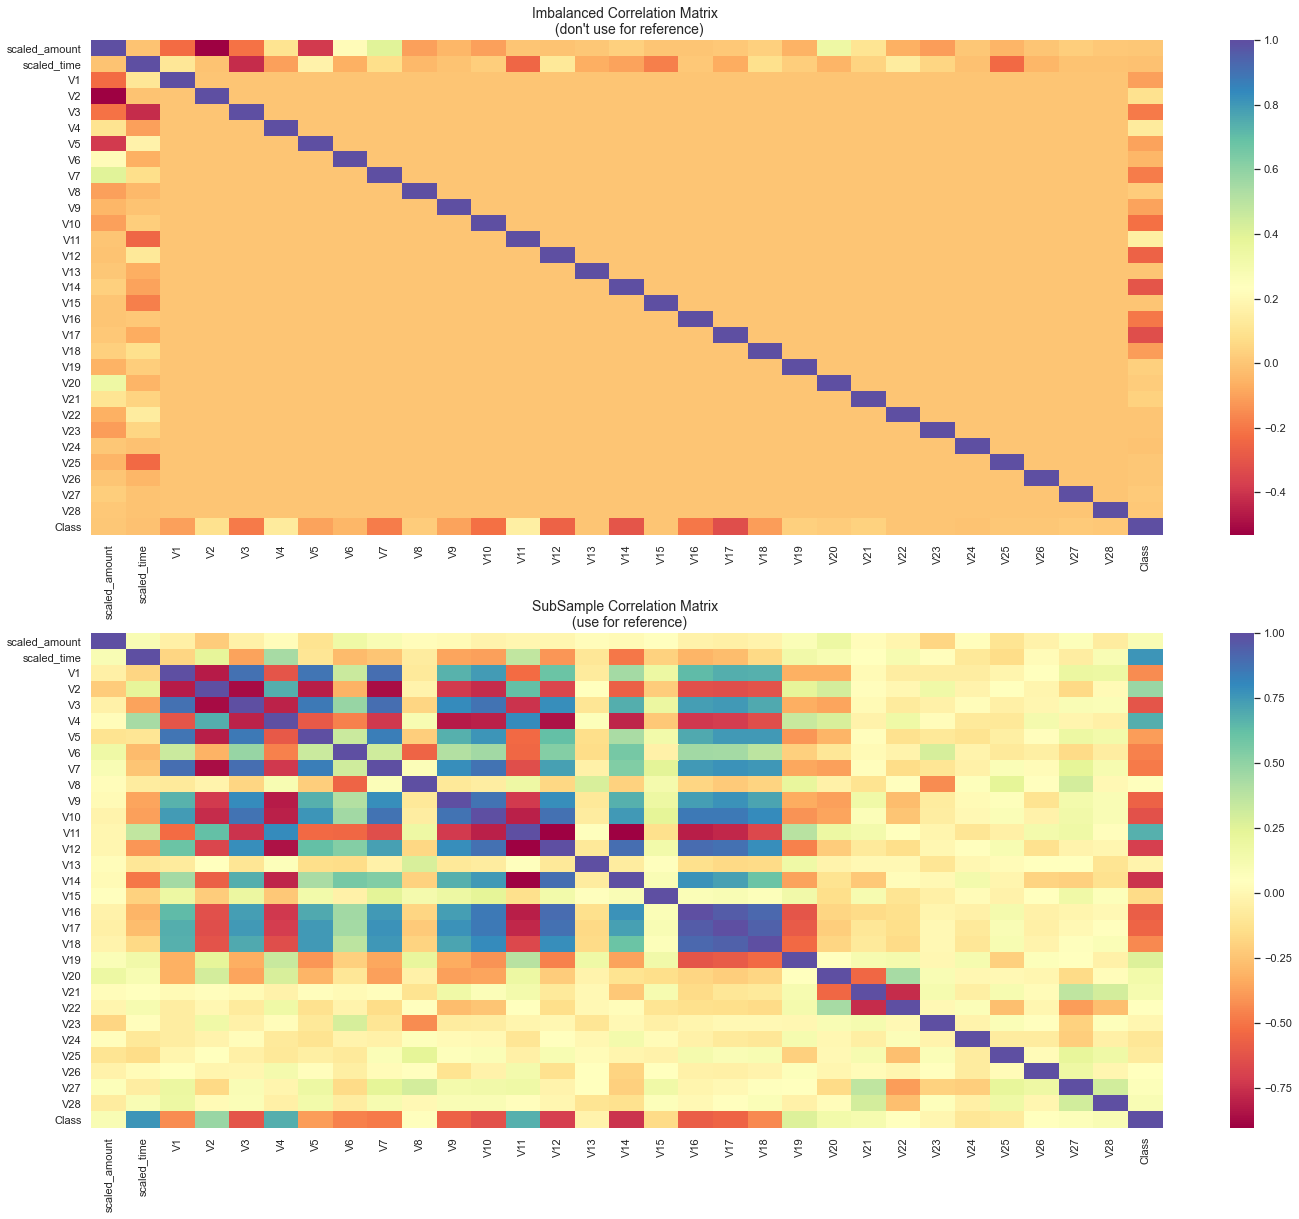

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='Spectral',annot_kws={'size':20},  ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = balanced_data.corr()
sns.heatmap(sub_sample_corr, cmap='Spectral',annot_kws={'size':20} ,ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

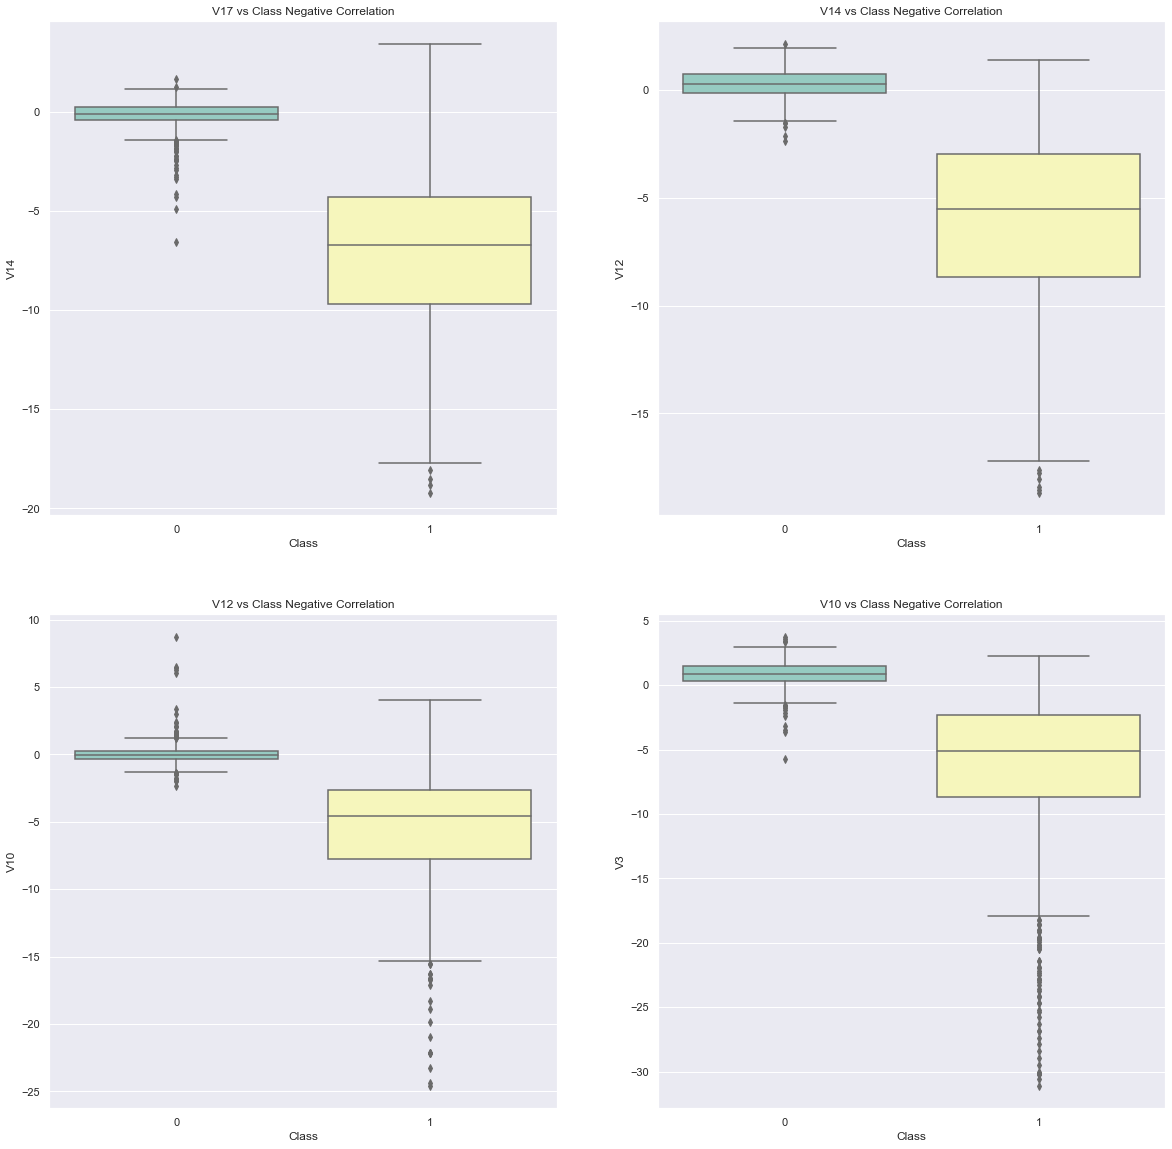

In [11]:
# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
f, axes = plt.subplots( nrows=2, ncols=2, figsize=(20,20))

sns.boxplot(x="Class", y="V14", data=balanced_data, palette="Set3", ax=axes[0,0])
axes[0,0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=balanced_data, palette="Set3", ax=axes[0,1])
axes[0,1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=balanced_data, palette="Set3", ax=axes[1,0])
axes[1,0].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V3", data=balanced_data, palette="Set3", ax=axes[1,1])
axes[1,1].set_title('V10 vs Class Negative Correlation')

plt.show()

Text(0.5, 1.0, 'V2 vs Class positive Correlation')

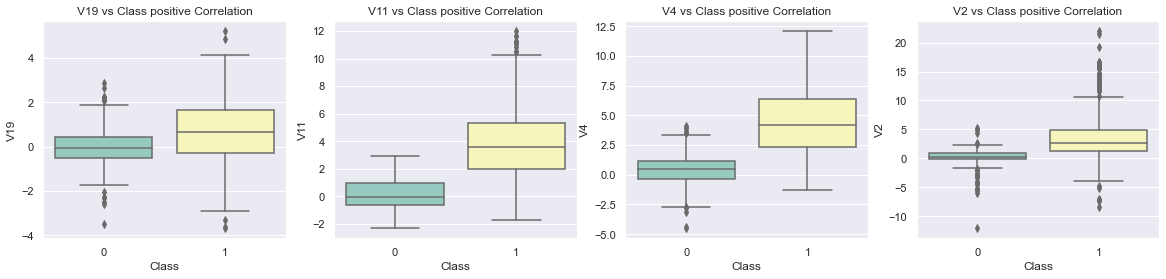

In [12]:
# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)

f, axes = plt.subplots( nrows=1 , ncols= 4, figsize=(20,4))

sns.boxplot(x="Class", y="V19", data=balanced_data, palette="Set3", ax=axes[0])
axes[0].set_title('V19 vs Class positive Correlation')

sns.boxplot(x="Class", y="V11", data=balanced_data, palette="Set3", ax=axes[1])
axes[1].set_title('V11 vs Class positive Correlation')


sns.boxplot(x="Class", y="V4", data=balanced_data, palette="Set3", ax=axes[2])
axes[2].set_title('V4 vs Class positive Correlation')


sns.boxplot(x="Class", y="V2", data=balanced_data, palette="Set3", ax=axes[3])
axes[3].set_title('V2 vs Class positive Correlation')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

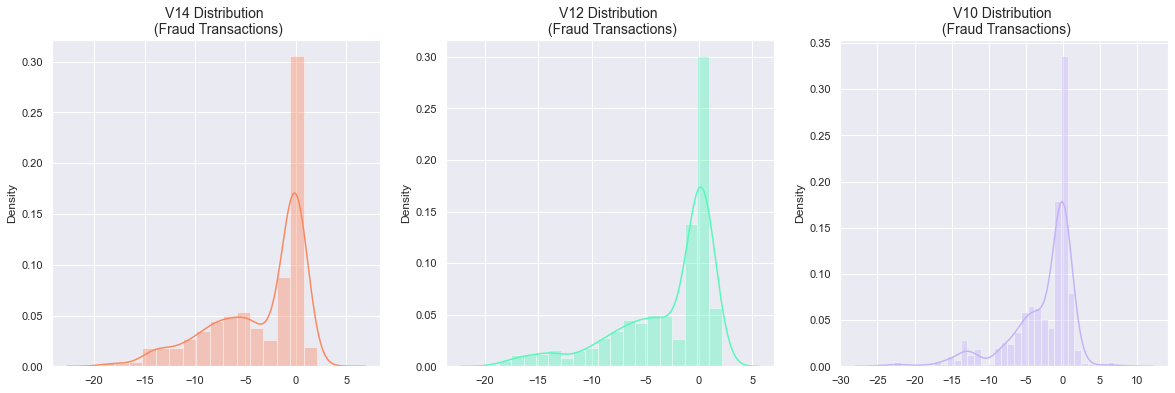

In [13]:

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = balanced_data['V14'].values
sns.distplot(v14_fraud_dist,ax=ax1, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = balanced_data['V12'].values
sns.distplot(v12_fraud_dist,ax=ax2, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = balanced_data['V10'].values
sns.distplot(v10_fraud_dist,ax=ax3, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [14]:
# Removing outliers V10 Feature
v10_fraud = balanced_data['V10'].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off

print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]

print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))

balanced_data = balanced_data.drop(balanced_data[(balanced_data['V10'] > v10_upper) | (balanced_data['V10'] < v10_lower)].index)

print('Number of Instances after outliers removal: {}'.format(len(balanced_data)))

V10 Lower: -11.429865085889386
V10 Upper: 6.857661748278084
V10 outliers: [8.73745780611353, -12.8409338181318, -13.1934150665232, -11.853866972600999, -11.5619497720699, -13.136698369103902, -11.797181067577698, -11.7121866242875, -11.6271935556579, -11.786811655604101, -13.6705451263516, -12.9389293107706, -14.166794659606, -13.3482776536659, -13.2616517082667, -13.175198078736, -13.0888909176936, -13.002709301069698, -12.916636109170899, -12.8306571996417, -12.7447607871859, -13.6913151328525, -11.435623996076, -12.981619145004, -11.6344144245911, -11.519860926414198, -11.589748311433, -12.2653238444006, -13.386683439524601, -13.2151722995049, -12.8881582878915, -12.805683189811699, -13.608143162727899, -12.835737682533901, -13.0740681657723, -12.6959474039839, -12.780633936202099, -14.676470249746401, -15.124162814494698, -14.226698057528699, -13.0094028057641, -14.110184441545698, -14.557159052885899, -16.6496281595399, -18.2711681738888, -13.540168238225, -12.0111608836062, -12.9

In [15]:
# Removing outliers V12 Feature
V12_fraud = balanced_data['V12'].values
q25, q75 = np.percentile(V12_fraud, 25), np.percentile(V12_fraud, 75)
V12_iqr = q75 - q25
V12_cut_off = V12_iqr * 1.5
V12_lower, V12_upper = q25 - V12_cut_off, q75 + V12_cut_off

print('V12 Lower: {}'.format(V12_lower))
print('V12 Upper: {}'.format(V12_upper))

outliers = [x for x in V12_fraud if x < V12_lower or x > V12_upper]

print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))

balanced_data = balanced_data.drop(balanced_data[(balanced_data['V12'] > V12_upper) | (balanced_data['V12'] < V12_lower)].index)

print('Number of Instances after outliers removal: {}'.format(len(balanced_data)))

V12 Lower: -11.029383362668607
V12 Upper: 7.281273672557531
V12 outliers: [-15.969207520809, -11.3490285500915, -11.1240186070579, -13.104933466201198, -11.6356300484755, -14.2750918465127, -14.4686550955305, -18.553697009645802, -18.4311310279993, -17.1504052507291, -11.1024933822497]
Feature V12 Outliers for Fraud Cases: 11
Number of Instances after outliers removal: 893


In [16]:
# Removing outliers V14 Feature
V14_fraud = balanced_data['V14'].values
q25, q75 = np.percentile(V14_fraud, 25), np.percentile(V14_fraud, 75)
V14_iqr = q75 - q25
V14_cut_off = V14_iqr * 1.5
V14_lower, V14_upper = q25 - V14_cut_off, q75 + V14_cut_off

print('V14 Lower: {}'.format(V14_lower))
print('V14 Upper: {}'.format(V14_upper))

outliers = [x for x in V14_fraud if x < V14_lower or x > V14_upper]

print('V14 outliers: {}'.format(outliers))
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))

balanced_data = balanced_data.drop(balanced_data[(balanced_data['V14'] > V14_upper) | (balanced_data['V14'] < V14_lower)].index)

print('Number of Instances after outliers removal: {}'.format(len(balanced_data)))

V14 Lower: -13.58626676794948
V14 Upper: 8.197113025525324
V14 outliers: [-14.266836279802801, -13.9694706254616, -13.725684613436101]
Feature V14 Outliers for Fraud Cases: 3
Number of Instances after outliers removal: 890


In [17]:
# 50 / 50 dataset again
num_one_targets = int(np.sum(balanced_data['Class']))
zero_targets_counter = 0
indices_to_remove = []

for i in range(balanced_data.shape[0]):
    if balanced_data['Class'].iloc[i] == 0:
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            indices_to_remove.append(i)
            
balanced_data = balanced_data.drop(balanced_data.index[indices_to_remove])

print('No Frauds', round(balanced_data['Class'].value_counts()[0]/len(balanced_data) * 100,2), '% of the dataset')
print('Frauds', round(balanced_data['Class'].value_counts()[1]/len(balanced_data) * 100,2), '% of the dataset')

No Frauds 50.0 % of the dataset
Frauds 50.0 % of the dataset


In [18]:
dataset = balanced_data
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [20]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C= 0.001, penalty= 'none' , solver= 'lbfgs' , random_state = 0)
classifier.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


LogisticRegression(C=0.001, penalty='none', random_state=0)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97        95
           1       0.98      0.97      0.98       105

    accuracy                           0.97       200
   macro avg       0.97      0.98      0.97       200
weighted avg       0.98      0.97      0.98       200



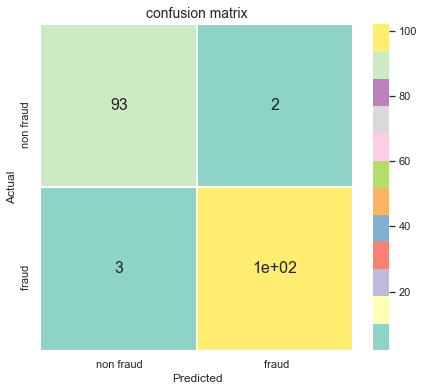

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score , classification_report

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

y_true = ["non fraud"," fraud"]
y_pred = ["non fraud"," fraud"]

df_cm = pd.DataFrame(cm, columns=(y_true), index = (y_pred))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

f, (ax1) = plt.subplots(1, 1, figsize=(7,6))
sns.heatmap(df_cm,linewidths=0.5, cmap="Set3", annot=True,annot_kws={"size": 16},  ax=ax1)
ax1.set_title("confusion matrix", fontsize=14)
plt.show()

In [22]:
## Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 97.99 %
Standard Deviation: 1.25 %


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' w

Reference:

https://www.kaggle.com/atharvaingle/credit-card-fraud-detection-with-r-sampling

https://www.kaggle.com/mohamedelbeih/eda-logistic-reg-model-accuracy-98